In [1]:
# 가상 데이터 생성
import numpy as np

np.random.seed(seed=1)
N = 200           # 데이터 갯수
K = 3             # 클래스 갯수
T = np.zeros((N,3), dtype =np.uint8)
X = np.zeros((N,2))
X_range0 = [-3,3]
X_range1 = [-3,3]
Mu = np.array([[-0.5,-0.5], [0.5, 1.0], [1, -0.5]])
Sig = np.array([[0.7,0.7],[0.8,0.8],[0.3,0.8]])
Pi = np.array([0.4,0.8,1])
for n in range(N):
    wk = np.random.rand()
    for k in range(K):
        if wk<Pi[k]:
            T[n,k] = 1
            break
    for k in range(2):
        X[n,k] = np.random.randn() * Sig[T[n,:]==1,k] + Mu[T[n,:]==1,k]

TestRatio = 0.5
X_n_training = int(N*TestRatio)
X_train = X[:X_n_training,:]
X_test = X[X_n_training:,:]
T_train = T[:X_n_training,:]
T_test = T[X_n_training:,:]

np.savez('class_data.npz', X_train=X_train,T_train=T_train,X_test=X_test,T_test=T_test,X_range0=X_range0,X_range1=X_range1)


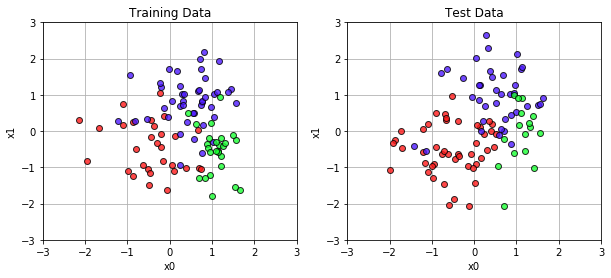

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

def Show_data(x,t):
    wk, n = t.shape
    c = [[1,0.1,0.1],[0.3,0.1,1],[0.1,1,0.2]]
    for i in range(n):
        plt.plot(x[t[:,i]==1,0],x[t[:,i]==1,1],
                linestyle='none', marker='o',markeredgecolor='black',
                color=c[i], alpha=0.8)
        plt.grid(True)
        
plt.figure(1,figsize=(10,4))
plt.subplot(1,2,1)
Show_data(X_train,T_train)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Training Data')

plt.subplot(1,2,2)
Show_data(X_test,T_test)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Test Data')
plt.show()


In [3]:
def Sigmoid(x):
    y = 1/(1 + np.exp(-x))
    return y

def FNN(wv,M,K,x):
    N, D = x.shape                 # N : 데이터 갯수, D : 입력의 갯수, D+1 : 입력 수 + 바이어스 
    W = wv[:M*(D+1)]        
    W = W.reshape(M,(D+1))         # 입력층 -> 중간층 매개변수 w 
    V = wv[M*(D+1):]
    V = V.reshape((K,M+1))         # 중간층 -> 출력층 매개변수 v
    
    b = np.zeros((N,M+1))          # 중간층 노드 입력
    z = np.zeros((N,M+1))          # 중간층 노드 출력
    a = np.zeros((N,K))            # 출력층 노드 입력
    y = np.zeros((N,K))            # 출력층 노드 출력
    
    for n in range(N):
        for m in range(M):
            b[n,m] = np.dot(W[m,:],np.r_[x[n,:],1])           #np.r_ : append elements, np.dot : 행렬 곱 연산
            z[n,m] = Sigmoid(b[n,m])
        z[n,M] = 1             # 중간층 바이어스 출력
        wkz = 0               # 
        for k in range(K):
            a[n,k] = np.dot(V[k,:],z[n,:])        # 출력층 입력 
            wkz = wkz + np.exp(a[n,k])           # 소프트 맥스 출력을 위한 분모 계산
        for k in range(K):
            y[n,k] = np.exp(a[n,k])/wkz         # 소프트 맥스 출력 
    return y,a,z,b

WV = np.ones(15)
M = 2           # 중간층(Hidden Layer) 노드 수 
K = 3           # 출력 노드 수 (Class 수)
FNN(WV,M,K,X_train[:2,:])

(array([[0.33333333, 0.33333333, 0.33333333],
        [0.33333333, 0.33333333, 0.33333333]]),
 array([[2.63489817, 2.63489817, 2.63489817],
        [1.49172649, 1.49172649, 1.49172649]]),
 array([[0.81744908, 0.81744908, 1.        ],
        [0.24586324, 0.24586324, 1.        ]]),
 array([[ 1.49915948,  1.49915948,  0.        ],
        [-1.12079826, -1.12079826,  0.        ]]))

In [4]:
def CE_FNN(wv,M,K,x,t):
    N,D  = x.shape
    y,a,z,b = FNN(wv,M,K,x)
    ce = -np.dot(np.log(y.reshape(-1)), t.reshape(-1))/N
    return ce

WV = np.ones(15)
M = 2
K = 3
CE_FNN(WV,M,K,X_train[:2,:],T_train[:2,:])

1.0986122886681098

[ 0.08741911  0.1828856  -0.04390391  0.01041191 -0.09957344 -0.12547068
 -0.0235438   0.00931146 -0.10360719 -0.11300486 -0.08049385 -0.46980491
  0.13654867  0.07118239  0.57341211]


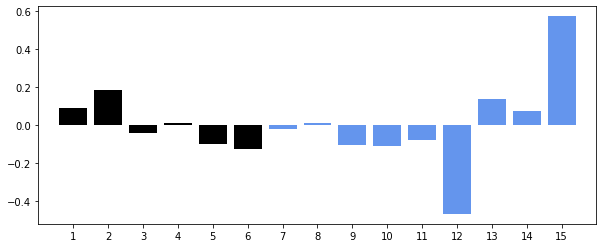

In [5]:


def dCE_FNN_num(wv,M,K,x,t):
    epsilon = 0.001
    dwv = np.zeros_like(wv)
    for iwv in range(len(wv)):
        wv_modified = wv.copy()
        wv_modified[iwv] = wv[iwv] - epsilon
        mse1 = CE_FNN(wv_modified,M,K,x,t)
        wv_modified[iwv] = wv[iwv] + epsilon
        mse2 = CE_FNN(wv_modified,M,K,x,t)
        dwv[iwv] = (mse2-mse1) / (2*epsilon)
    return dwv

def Show_WV(wv,M):
    N = wv.shape[0]
    plt.bar(range(1,M*3+1), wv[:M*3],align="center", color="black")
    plt.bar(range(M*3+1,N+1), wv[M*3:], align="center", color="cornflowerblue")
    plt.xticks(range(1,N+1))
    plt.xlim(0,N+1)
    
    
M = 2
K = 3
nWV = M*3 + K*(M+1)
np.random.seed(1)
WV = np.random.normal(0,1,nWV)
dWV = dCE_FNN_num(WV,M,K,X_train[:2,:],T_train[:2,:])
print(dWV)
plt.figure(1,figsize=(10,4))
Show_WV(dWV,M)
plt.show()

In [14]:
import time

def Fit_FNN_num(wv_init,M,K,x_train,t_train,x_test,t_test,n,alpha):   # 수치해석적 FNN 최적화
    wvt = wv_init
    err_train = np.zeros(n)
    err_test = np.zeros(n) 
    wv_hist = np.zeros((n,len(wv_init)))
    epsilon = 0.001
    for i in range(n) :
        wvt = wvt - alpha * dCE_FNN_num(wvt,M,K,x_train,t_train)
        err_train[i] = CE_FNN(wvt,M,K,x_train,t_train)
        err_test[i] = CE_FNN(wvt,M,K,x_test,t_test)
        wv_hist[i,:] = wvt
    return wvt, wv_hist, err_train, err_test

startTime = time.time()
M = 2
K = 3
np.random.seed(1)
WV_init = np.random.normal(0, 0.01, M*3 + K*(M+1))
N_step = 1000       # 스텝 단계
alpha = 0.5            # 학습률
WV, WV_hist, Err_train, Err_test = Fit_FNN_num(WV_init,M,K,X_train,T_train,X_test,T_test,N_step,alpha)

calculation_time = time.time() - startTime
print("Calculation time:{0:.3f} sec".format(calculation_time))

Calculation time:170.228 sec


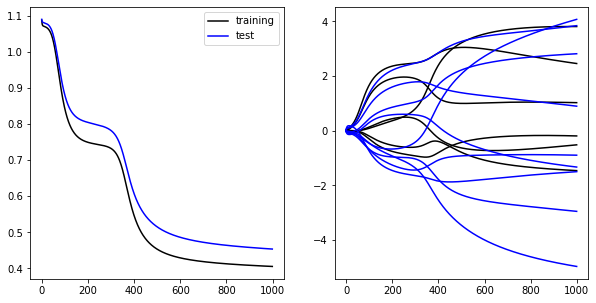

In [18]:
plt.figure(1, figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(Err_train, '-k', label='training')
plt.plot(Err_test, '-b', label='test')
plt.legend()

plt.subplot(1,2,2)
plt.plot(WV_hist[:,:M*3],'-k')
plt.plot(WV_hist[:,M*3:],'-b')
plt.show()

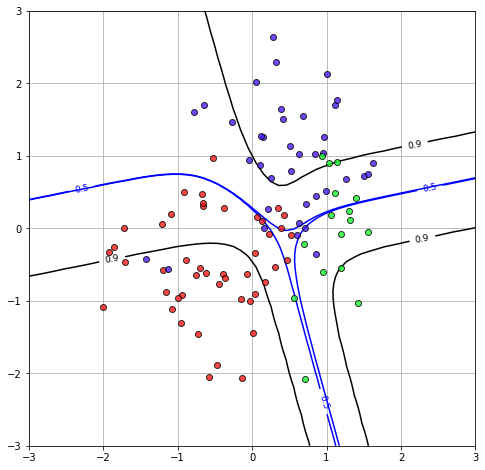

In [19]:
def show_FNN(wv,M,K):
    xn = 60
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    xx0, xx1 = np.meshgrid(x0,x1)
    x = np.meshgrid(x0,x1)
    x = np.c_[np.reshape(xx0,xn*xn,1), np.reshape(xx1,xn*xn,1)]
    y, a, z, b = FNN(wv,M,K,x)
    plt.figure(1, figsize=(4,4))
    for ic in range(K):
        f = y[:,ic]
        f = f.reshape(xn,xn)
        f = f.T
        cont = plt.contour(xx0,xx1,f,levels=[0.5,0.9],
                          colors = ['blue','black'])
        cont.clabel(fmt='%1.1f',fontsize=9)
    plt.xlim(X_range0)
    plt.ylim(X_range1)
    
plt.figure(1, figsize=(8,8))
Show_data(X_test,T_test)
show_FNN(WV,M,K)
plt.show()